In [7]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, utils
from PIL import Image
import os
import itertools
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
#

from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import os
import itertools
from PIL import Image

In [8]:
root_dir = "data"

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparametre

In [20]:
IMG_SIZE = 64
BATCH_SIZE = 16
LR = 0.0002
EPOCHS = 5
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 5.0

## Generator

In [11]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(True),
        ]

        for _ in range(6):
            model += [ResnetBlock(256)]

        model += [
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## Diskriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        model = [
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, padding=1)
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## Gradient penalty

In [13]:
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones_like(d_interpolates, device=device, requires_grad=False)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## Data loader

In [14]:
class ImageDataset(Dataset):
    def __init__(self, rootA, rootB, transform=None):
        self.files_A = sorted(os.listdir(rootA))[:100]  # use subset
        self.files_B = sorted(os.listdir(rootB))[:100]
        self.rootA = rootA
        self.rootB = rootB
        self.transform = transform

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

    def __getitem__(self, index):
        img_A = Image.open(os.path.join(self.rootA, self.files_A[index % len(self.files_A)])).convert("RGB")
        img_B = Image.open(os.path.join(self.rootB, self.files_B[index % len(self.files_B)])).convert("RGB")
        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)
        return {"A": img_A, "B": img_B}


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageDataset("data/apple2orange/apple2orange/trainA", "data/apple2orange/apple2orange/trainB", transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

optimizer_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

cycle_loss_fn = nn.L1Loss()


In [ ]:
## Train

In [21]:
for epoch in range(EPOCHS):  
    for i, batch in enumerate(dataloader):
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        # ---------------------
        #  Train Generators
        # ---------------------
        optimizer_G.zero_grad()

        fake_B = G_AB(real_A)
        rec_A = G_BA(fake_B)
        fake_A = G_BA(real_B)
        rec_B = G_AB(fake_A)

        loss_cycle_A = cycle_loss_fn(rec_A, real_A)
        loss_cycle_B = cycle_loss_fn(rec_B, real_B)

        loss_G_AB = -torch.mean(D_B(fake_B))
        loss_G_BA = -torch.mean(D_A(fake_A))

        loss_G = loss_G_AB + loss_G_BA + 10 * (loss_cycle_A + loss_cycle_B)
        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator A
        # ---------------------
        optimizer_D_A.zero_grad()
        loss_real = torch.mean(D_A(real_A))
        loss_fake = torch.mean(D_A(fake_A.detach()))
        gp = compute_gradient_penalty(D_A, real_A, fake_A.detach(), device)
        loss_D_A = -loss_real + loss_fake + 10 * gp
        loss_D_A.backward()
        optimizer_D_A.step()

        # ---------------------
        #  Train Discriminator B
        # ---------------------
        optimizer_D_B.zero_grad()
        loss_real = torch.mean(D_B(real_B))
        loss_fake = torch.mean(D_B(fake_B.detach()))
        gp = compute_gradient_penalty(D_B, real_B, fake_B.detach(), device)
        loss_D_B = -loss_real + loss_fake + 10 * gp
        loss_D_B.backward()
        optimizer_D_B.step()

        if i % 10 == 0:
            print(f"[Epoch {epoch}] [Batch {i}] Loss_G: {loss_G.item():.4f} Loss_D_A: {loss_D_A.item():.4f} Loss_D_B: {loss_D_B.item():.4f}")


[Epoch 0] [Batch 0] Loss_G: 9.5658 Loss_D_A: 1.8070 Loss_D_B: 1.2467
[Epoch 0] [Batch 10] Loss_G: 8.0063 Loss_D_A: 0.3590 Loss_D_B: 1.3076
[Epoch 0] [Batch 20] Loss_G: 7.7644 Loss_D_A: 0.1212 Loss_D_B: 0.9140
[Epoch 1] [Batch 0] Loss_G: 6.0596 Loss_D_A: 0.3922 Loss_D_B: 0.6224
[Epoch 1] [Batch 10] Loss_G: 5.6942 Loss_D_A: 1.9416 Loss_D_B: 1.0857
[Epoch 1] [Batch 20] Loss_G: 6.2086 Loss_D_A: 0.4429 Loss_D_B: 0.4112
[Epoch 2] [Batch 0] Loss_G: 7.4320 Loss_D_A: 0.2246 Loss_D_B: 0.5440
[Epoch 2] [Batch 10] Loss_G: 5.3335 Loss_D_A: 0.1527 Loss_D_B: 0.1600
[Epoch 2] [Batch 20] Loss_G: 5.0443 Loss_D_A: 0.5059 Loss_D_B: 0.5574
[Epoch 3] [Batch 0] Loss_G: 6.5290 Loss_D_A: 0.1937 Loss_D_B: 0.6153
[Epoch 3] [Batch 10] Loss_G: 6.0337 Loss_D_A: 0.6876 Loss_D_B: 0.5006
[Epoch 3] [Batch 20] Loss_G: 5.8821 Loss_D_A: 0.2422 Loss_D_B: 0.3337
[Epoch 4] [Batch 0] Loss_G: 5.6205 Loss_D_A: 0.6395 Loss_D_B: 0.3522
[Epoch 4] [Batch 10] Loss_G: 5.5179 Loss_D_A: 0.0790 Loss_D_B: 0.1619
[Epoch 4] [Batch 20] Loss

## Test

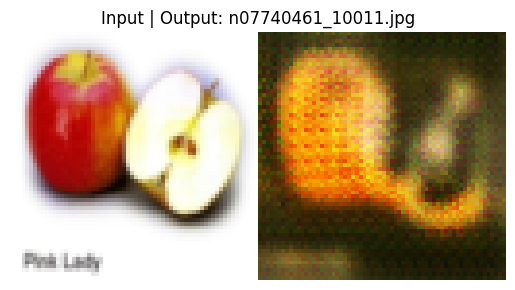

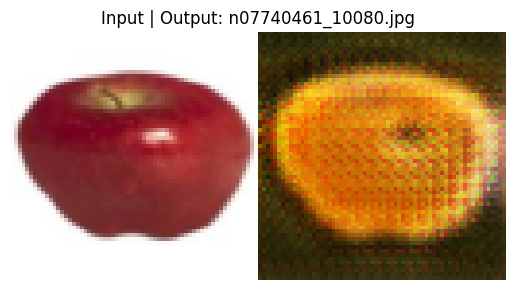

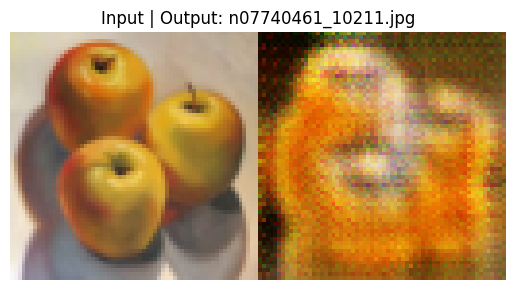

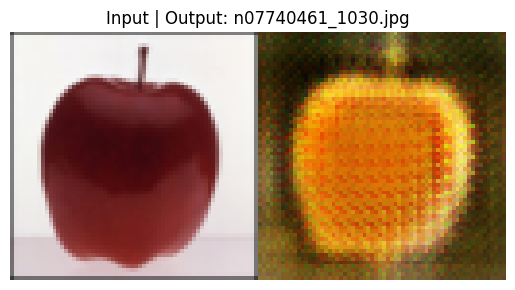

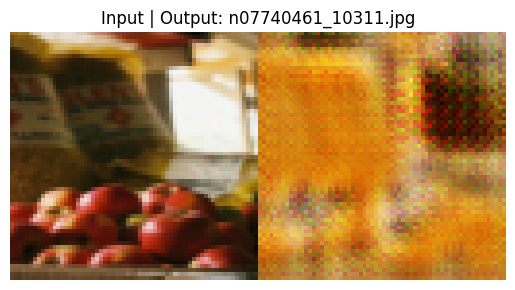

In [22]:
test_dir = "data/apple2orange/apple2orange/testA"
test_images = sorted(os.listdir(test_dir))[:5]

G_AB.eval()
with torch.no_grad():
    for i, fname in enumerate(test_images):
        img = Image.open(os.path.join(test_dir, fname)).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)
        fake = G_AB(img_tensor)
        result = torch.cat((img_tensor, fake), dim=3)
        result_img = (result.squeeze(0).cpu() + 1) / 2.0
        np_img = result_img.permute(1, 2, 0).numpy()
        plt.imshow(np_img)
        plt.title(f"Input | Output: {fname}")
        plt.axis('off')
        plt.show()
